In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#! pip3 install xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [2]:
data = pd.read_csv('Data/data_with_new_features.csv')
print(len(data))
data.head()

376912


,Unnamed: 0,id,time,variable,value,date,timeOfDay,year,month,day,phaseOfDay
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0,2014-02-26,13:00:00.000,2014,2,26,1
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0,2014-02-26,15:00:00.000,2014,2,26,1
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0,2014-02-26,18:00:00.000,2014,2,26,2
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0,2014-02-26,21:00:00.000,2014,2,26,2
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0,2014-02-27,09:00:00.000,2014,2,27,0


In [3]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']
The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


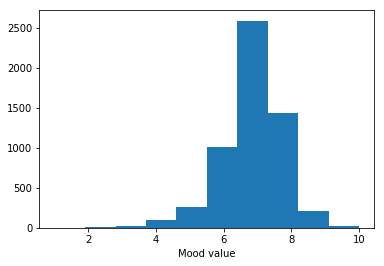

In [4]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


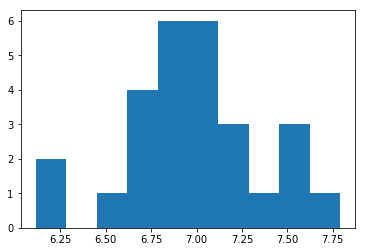

In [5]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()



In [6]:
#helper function to compare two dates, obsolete

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))






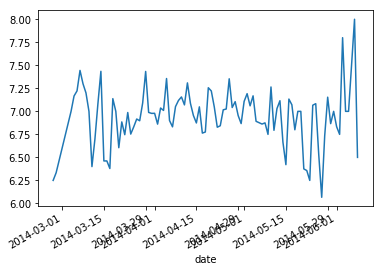

In [7]:
#getting dates and setting them as indexis
data["date"] = get_date_data_frame(data)
data['date'] = pd.to_datetime(data['date'])
data= data.set_index(['id', 'date'])

data[data['variable']=='mood']['value'].groupby(level = 'date').mean().plot()
plt.show()

Features to investigate and how to aggregate. <br />
Mood = average per day, average for t days <br /> circumplex.arousal = average<br /> circumplex.valence = average <br />
activity = average per day <br />
screen = sum per day,  average along several days, sum along days <br />
call = sum per day, average along several days, sum along days <br />
sms = sum per day, average along several days, sum along days <br />
for each in ['appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']:
 sum per day.  <br />
 
 Also days which are closer to t can be scored higher
 

In [100]:
variables = data['variable'].unique()
#generating new df
date_data = pd.DataFrame(index = data.index)
sum_variables =  [ 'screen',
 'call', 'sms' ,'appCat.builtin', 'appCat.communication',
 'appCat.entertainment', 'appCat.finance', 'appCat.game' ,'appCat.office',
 'appCat.other', 'appCat.social', 'appCat.travel' ,'appCat.unknown',
 'appCat.utilities' ,'appCat.weather']
mean_variables = ['mood', 'circumplex.arousal', 'circumplex.valence','activity']

#grouping by id and date. creating a column for value for that day with either mean or sum (described in markdown)
for variable in variables:
    if variable in sum_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].sum()#.reset_index(level=['id']).resample('D').sum()
    elif variable in mean_variables:
        date_data[variable] = data[data['variable']==variable].groupby(level = ['id', 'date'])['value'].mean()#.reset_index(level=['id']).resample('D').mean()

# add temporal variables
date_data['dayofweek'] = date_data.index.get_level_values('date').dayofweek
date_data['phaseOfDay'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['phaseOfDay'].mean()#.
date_data['day'] = data[data['variable']=="mood"].groupby(level = ['id', 'date'])['day'].mean()#.

# add leisure variable
date_data['leisure'] = (date_data['appCat.entertainment']+date_data['appCat.game'])

#target at day is the same as mood at day
date_data['target'] = date_data['mood']

#droping duplicates
date_data.drop_duplicates( keep='first', inplace=True)

#filling missing values were NaN means 0
values0 = {key: 0 for key in sum_variables}
values0['leisure'] = 0

date_data.fillna(value=values0, inplace=True)
#to do : think about values he didn't fill yet. although we have xgboost, so shouldn't be a problem

In [71]:
date_data.head()

mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000               -0.25            0.750000   
        2014-02-27  6.333333                0.00            0.333333   
        2014-03-21  6.200000                0.20            0.200000   
        2014-03-22  6.400000                0.60            0.500000   
        2014-03-23  6.800000                0.20            0.800000   

                    activity        screen  call  sms  appCat.builtin  \
id      date                                                            
AS14.01 2014-02-26       NaN      0.000000   1.0  2.0           0.000   
        2014-02-27       NaN      0.000000   0.0  0.0           0.000   
        2014-03-21  0.134050  17978.907000   6.0  0.0        3139.218   
        2014-03-22  0.236880   6142.161000   3.0  1.0         731.429   
        2014-03-23  0.142741   6773.832001   0.0  0.0        1286.246   

                    appCat.communication  appCat.entertainment  \
id      date                                                     
AS14.01 2014-02-26                 0.000                 0.000   
        2014-02-27                 0.000                 0.000   
        2014-03-21              6280.890              1007.456   
        2014-03-22              4962.918                93.324   
        2014-03-23              5237.319                94.346   

                    appCat.finance  appCat.game  appCat.office  appCat.other  \
id      date                                                                   
AS14.01 2014-02-26           0.000          0.0          0.000         0.000   
        2014-02-27           0.000          0.0          0.000         0.000   
        2014-03-21          49.544          0.0        172.206       239.751   
        2014-03-22          21.076          0.0          0.000        98.143   
        2014-03-23          43.403          0.0          0.000        72.823   

                    appCat.social  appCat.travel  appCat.unknown  \
id      date                                                       
AS14.01 2014-02-26          0.000          0.000             0.0   
        2014-02-27          0.000          0.000             0.0   
        2014-03-21       4508.500        915.445             0.0   
        2014-03-22        439.632         37.305             0.0   
        2014-03-23        900.839          0.000             0.0   

                    appCat.utilities  appCat.weather    target  
id      date                                                    
AS14.01 2014-02-26             0.000           0.000  6.250000  
        2014-02-27             0.000           0.000  6.333333  
        2014-03-21           598.754           0.000  6.200000  
        2014-03-22           117.621           0.000  6.400000  
        2014-03-23            30.086          30.386  6.800000

In [73]:
# get information about new features
date_data.corr(method='pearson')['target']

mood                    1.000000
circumplex.arousal      0.155405
circumplex.valence      0.685379
activity                0.167145
screen                  0.043663
call                    0.026995
sms                    -0.042953
appCat.builtin          0.014166
appCat.communication    0.051973
appCat.entertainment    0.088823
appCat.finance          0.018168
appCat.game             0.070243
appCat.office           0.040167
appCat.other            0.083512
appCat.social          -0.050629
appCat.travel           0.024028
appCat.unknown          0.030043
appCat.utilities        0.041467
appCat.weather          0.018071
target                  1.000000
Name: target, dtype: float64

In [102]:
lagged_date_data = date_data.copy()
#rolling mean
lag = 10
rolling_variables  = list(lagged_date_data.columns)
rolling_variables.remove("dayofweek")
rolling_variables.remove("day")

#for lag in range(1,max_lag):
for variable in rolling_variables:
    if variable == "day" or variable == "dayofweek":
        lagged_date_data[variable+"_not_lagged"] = lagged_date_data[variable]
    else:
        lagged_date_data["{}_lagged_by_{}".format(variable, lag)]=lagged_date_data[variable].rolling(window = lag).mean()

In [103]:
print("users:",len(lagged_date_data.index.get_level_values('id').unique()))
print("data points (user-date pairs):",len(lagged_date_data.index.get_level_values('id')))
lagged_date_data

users: 27
data points (user-date pairs): 1564


mood  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-26  6.250000           -0.250000            0.750000   
        2014-02-27  6.333333            0.000000            0.333333   
        2014-03-21  6.200000            0.200000            0.200000   
        2014-03-22  6.400000            0.600000            0.500000   
        2014-03-23  6.800000            0.200000            0.800000   
        2014-03-24  6.000000            0.800000            0.000000   
        2014-03-25  6.750000            0.500000            0.500000   
        2014-03-26  6.600000           -0.200000            0.600000   
        2014-03-27  7.000000            0.200000            0.800000   
        2014-03-28  6.400000           -0.600000            0.600000   
        2014-03-29  8.000000            0.200000            1.000000   
        2014-03-30  7.500000           -0.500000            0.750000   
        2014-03-31  7.400000            0.000000            0.600000   
        2014-04-01  6.000000            0.200000            0.000000   
        2014-04-02  6.500000            0.333333            0.666667   
        2014-04-03  6.400000           -1.200000            0.000000   
        2014-04-04  6.200000            0.200000            0.400000   
        2014-04-05  6.800000           -0.400000            0.600000   
        2014-04-06  6.500000           -0.750000            0.500000   
        2014-04-07  6.500000           -0.666667            0.250000   
        2014-04-08  6.600000           -0.400000            0.333333   
        2014-04-09  7.400000           -0.800000            1.000000   
        2014-04-10  7.400000           -0.400000            0.800000   
        2014-04-11  7.000000           -1.200000            0.800000   
        2014-04-12  7.250000           -0.750000            0.750000   
        2014-04-13  8.000000           -1.250000            1.000000   
        2014-04-14  7.200000           -1.200000            0.600000   
        2014-04-15  6.400000            0.000000            0.800000   
        2014-04-16  7.200000            0.750000            0.500000   
        2014-04-17  6.600000           -0.400000            0.600000   
...                      ...                 ...                 ...   
        2014-03-17       NaN                 NaN                 NaN   
AS14.03 2014-02-26       NaN                 NaN                 NaN   
AS14.06 2014-02-22       NaN                 NaN                 NaN   
        2014-02-23       NaN                 NaN                 NaN   
        2014-02-24       NaN                 NaN                 NaN   
        2014-02-26       NaN                 NaN                 NaN   
        2014-02-28       NaN                 NaN                 NaN   
        2014-03-15       NaN                 NaN                 NaN   
        2014-03-16       NaN                 NaN                 NaN   
        2014-03-20       NaN                 NaN                 NaN   
        2014-03-22       NaN                 NaN                 NaN   
AS14.08 2014-02-17       NaN                 NaN                 NaN   
        2014-02-18       NaN                 NaN                 NaN   
        2014-02-28       NaN                 NaN                 NaN   
AS14.12 2014-03-09       NaN                 NaN                 NaN   
AS14.13 2014-03-04       NaN                 NaN                 NaN   
AS14.14 2014-02-22       NaN                 NaN                 NaN   
AS14.17 2014-02-17       NaN                 NaN                 NaN   
        2014-03-01       NaN                 NaN                 NaN   
AS14.20 2014-02-21       NaN                 NaN                 NaN   
        2014-03-06       NaN                 NaN                 NaN   
AS14.23 2014-02-23       NaN                 NaN                 NaN   
AS14.24 2014-04-09       NaN                 NaN                

In [80]:
lagged_date_data.corr(method='pearson')['target']

mood                                 1.000000
circumplex.arousal                   0.152953
circumplex.valence                   0.685227
activity                             0.167145
screen                               0.044116
call                                 0.027335
sms                                 -0.042579
appCat.builtin                       0.014357
appCat.communication                 0.052336
appCat.entertainment                 0.088920
appCat.finance                       0.018277
appCat.game                          0.070238
appCat.office                        0.040168
appCat.other                         0.083600
appCat.social                       -0.050132
appCat.travel                        0.024133
appCat.unknown                       0.030130
appCat.utilities                     0.041552
appCat.weather                       0.018164
dayofweek                            0.096071
phaseOfDay                          -0.021719
day                               

In [104]:
#creating variables to drop
#BUG SLIDE TO T-1
list_var = rolling_variables
print(list_var)
list_var.remove('target')
#fill target   MSE: 0.2652, don't think it's valid
#date_data['target'].fillna(method = "ffill", inplace=1)

# drop nan target MSE: 0.3179
#133 nan targets

lagged_date_data.dropna(axis = 0,subset = ["target"], inplace=True)
test = lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var)
test

['mood', 'circumplex.arousal', 'circumplex.valence', 'activity', 'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'phaseOfDay', 'leisure', 'target']


,dayofweek,day,target,mood_lagged_by_10,circumplex.arousal_lagged_by_10,circumplex.valence_lagged_by_10,activity_lagged_by_10,screen_lagged_by_10,call_lagged_by_10,sms_lagged_by_10,...,appCat.office_lagged_by_10,appCat.other_lagged_by_10,appCat.social_lagged_by_10,appCat.travel_lagged_by_10,appCat.unknown_lagged_by_10,appCat.utilities_lagged_by_10,appCat.weather_lagged_by_10,phaseOfDay_lagged_by_10,leisure_lagged_by_10,target_lagged_by_10
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,2,26.0,6.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,3,27.0,6.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-21,4,21.0,6.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-22,5,22.0,6.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-23,6,23.0,6.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-24,0,24.0,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-25,1,25.0,6.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-26,2,26.0,6.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-27,3,27.0,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
feature_data = np.array(test)#lagged_date_data.reset_index(level='id').drop(axis=1, labels='id').drop(axis=1, labels = list_var))
x, y =np.concatenate((feature_data[:-1,3:], feature_data[1:,0:2]), axis = 1), feature_data[1:,2]

seed = 42
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [109]:
y_pred = model.predict(X_test)

#print(y_test, predictions)
accuracy = mean_squared_error(y_test, y_pred)
print("MSE: {:.4}" .format(accuracy))
print(X_test.shape)

MSE: 0.3578
(419, 24)


In [15]:
#baseline  MSE: 0.5868
baseline_vector = []
for i, m in enumerate(date_data['mood']):
    if i==0:
        continue
    baseline_vector.append(date_data['mood'].iloc[i-1])

x, y =np.array(baseline_vector).reshape(-1,1) , np.array(date_data['mood']).reshape(-1,1)

accuracy = mean_squared_error(y[1:], x)
print("MSE: {:.4}" .format(accuracy))

MSE: 0.5819
